In [26]:
import open3d
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import copy

import matplotlib.pyplot as plt
import utils.registration as registration
import utils.functions as functions
import utils.transform as transform
import utils.pointcloud as pointcloud
import utils.fread as fread
import utils.FCGF as FCGF

from utils.config import Config
from utils.depth_camera import DepthCamera, DepthCameraParams
from scipy.ndimage import gaussian_filter1d
from PIL import Image

In [28]:
config = Config(
    sequence_dir="../liloc/data/raw_data",
    feature_dir="../liloc/data/features",
    output_dir="../liloc/data/trajectories/temp",
    experiment="exp_11",
    trial="trial_1",
    subject="subject-1",
    sequence="02",
    groundtruth_dir="data/trajectories/groundtruth",
)

In [29]:
camera_params = DepthCameraParams("../liloc/data/raw_data/exp_11/metadata/device-3-aligned.json")
depth_camera = DepthCamera(camera_params)

In [8]:
sequence_dir = config.get_sequence_dir()
motion_dir = config.get_motion_dir()

sequence_ts = fread.get_timstamps_from_images(sequence_dir, ext=".depth.png")

accel_df = pd.read_csv(os.path.join(motion_dir, "accel.csv"))
gyro_df = pd.read_csv(os.path.join(motion_dir, "gyro.csv"))

accel_df.drop_duplicates("timestamp", inplace=True)
gyro_df.drop_duplicates("timestamp", inplace=True)
imu_df = pd.merge(accel_df, gyro_df, on="timestamp", suffixes=("a", "g"))

In [9]:
elapsed_time = (sequence_ts - sequence_ts[0]) / 1e3
calibration_ts = np.where(elapsed_time < 5)[0]
sequence_ts = np.delete(sequence_ts, calibration_ts)

In [30]:
data = dict()

for i in range(imu_df.shape[0]):
    v = imu_df.iloc[i].values
    data[int(v[0])] = v
    
for i in range(len(sequence_ts)):
    depth_image = DepthCamera.read_depth_image(os.path.join(sequence_dir, f"frame-{sequence_ts[i]}.depth.png"))
    pcd = depth_camera.depth_image_to_point_cloud(depth_image)
    data[sequence_ts[i]] = np.asarray(pcd.points)

In [31]:
timestamps = sorted(data.keys())

In [32]:
imu_data = np.array([]).reshape(0, 7)
filtered_imu_data = np.array([]).reshape(0, 7)
pcd_data = []
calibrated = False
gravity = None
window_len = 1600
velocity = np.zeros(3)
dt = 0.0025
local_t = [np.identity(4)]

for t in timestamps:
    if data[t].ndim == 1:
        imu_data = np.concatenate([imu_data, data[t].reshape(1, -1)], axis=0)
        if calibrated:
            imu_data[-1, 1:4] = imu_data[-1, 1:4] - gravity
            # moving average filter
            avg = np.mean(imu_data[-window_len:, 1:4], axis=0)
            imu_data_copy = imu_data[-1].copy()
            imu_data_copy[1:4] = imu_data_copy[1:4] - avg
            filtered_imu_data = np.concatenate([filtered_imu_data, imu_data_copy.reshape(1, -1)], axis=0)
    else:
        pcd = pointcloud.make_pcd(data[t])
        pcd = open3d.voxel_down_sample(pcd, voxel_size=0.05)
        pcd_data.append(pcd)
        
        if not calibrated:
            # calculate gravity vector
            imu_data = np.array(imu_data)
            gravity = np.mean(imu_data, axis=0)[1:4]
            imu_data[:, 1:4] = imu_data[:, 1:4] - gravity
            calibrated = True
        else:
            if len(filtered_imu_data) == 0:
                break
            
            rotation_matrix = np.identity(4)
            translation = np.zeros(3)
            
            for i in range(len(filtered_imu_data[:, 0] <= t)):
                v = filtered_imu_data[i]
                
                # current displacement and rotation
                da = np.degrees([v[j + 4] * dt for j in range(3)])
                
                acceleration = v[1:4]

                d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
                d = np.dot(rotation_matrix, np.array([*d, 1]))
                
                translation = translation + d[:3]
                velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]
                
                rotation_matrix = transform.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
                
            trans_mat = np.identity(4)
            trans_mat[:3, 3] = translation
            trans_mat[:3, :3] = rotation_matrix[:3, :3]

            source = copy.deepcopy(pcd_data[-1])
            target = copy.deepcopy(pcd_data[-2])

            refined_transform = registration.exec_icp(source, target, 0.05, trans_mat, 200)
            registration.describe(source, target, refined_transform)
            # registration.view(source, target, refined_transform.transformation)
            refined_transform = refined_transform.transformation
            
            # velocity = refined_transform[:3, 3] * 1e3 / (filtered_imu_data[-1, 0] - filtered_imu_data[0, 0])
            local_t.append(refined_transform)

            # filtered_imu_data = np.array([]).reshape(0, 7)
            filtered_imu_data = filtered_imu_data[filtered_imu_data[:, 0] > t]

Keypts: [9236, 9331]	No of matches: 8973	Fitness: 0.9715	Inlier RMSE: 0.0181
Keypts: [9297, 9236]	No of matches: 8917	Fitness: 0.9591	Inlier RMSE: 0.0176
Keypts: [9305, 9297]	No of matches: 8951	Fitness: 0.9620	Inlier RMSE: 0.0176
Keypts: [9146, 9305]	No of matches: 8773	Fitness: 0.9592	Inlier RMSE: 0.0185
Keypts: [8948, 9146]	No of matches: 8646	Fitness: 0.9662	Inlier RMSE: 0.0177
Keypts: [9039, 8948]	No of matches: 8791	Fitness: 0.9726	Inlier RMSE: 0.0163
Keypts: [8995, 9039]	No of matches: 8775	Fitness: 0.9755	Inlier RMSE: 0.0156
Keypts: [8914, 8995]	No of matches: 8706	Fitness: 0.9767	Inlier RMSE: 0.0163
Keypts: [8729, 8914]	No of matches: 8572	Fitness: 0.9820	Inlier RMSE: 0.0151
Keypts: [8656, 8729]	No of matches: 8418	Fitness: 0.9725	Inlier RMSE: 0.0159
Keypts: [8750, 8656]	No of matches: 8535	Fitness: 0.9754	Inlier RMSE: 0.0158
Keypts: [8741, 8750]	No of matches: 8498	Fitness: 0.9722	Inlier RMSE: 0.0160
Keypts: [8682, 8741]	No of matches: 8406	Fitness: 0.9682	Inlier RMSE: 0.0180

In [33]:
num_frames = len(local_t)
trajectory_t = [np.identity(4)]

for t in tqdm.trange(1, num_frames):
    trajectory_t.append(np.dot(trajectory_t[t - 1], local_t[t]))
    
trajectory_pcd = []

for i in range(num_frames):
    pcd = copy.deepcopy(pcd_data[i])
    pcd.transform(trajectory_t[i])
    trajectory_pcd.append(pcd)
    
trajectory = pointcloud.merge_pcds(trajectory_pcd, 0.03)

open3d.visualization.draw_geometries([trajectory])

100%|██████████| 438/438 [00:00<00:00, 145790.43it/s]


In [197]:
for i in range(50, 55):
    source = copy.deepcopy(pcd_data[i])
    target = copy.deepcopy(pcd_data[i - 1])
    
    registration.view(source, target, local_t[i])

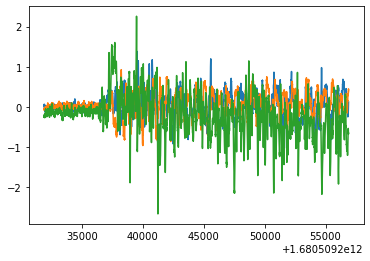

In [198]:
plt.plot(imu_data[:, 0], imu_data[:, 1])
plt.plot(imu_data[:, 0], imu_data[:, 2])
plt.plot(imu_data[:, 0], imu_data[:, 3])

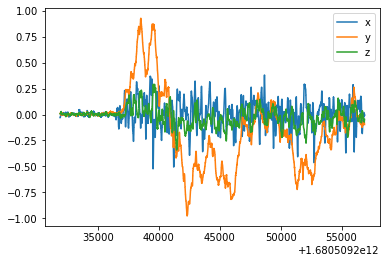

In [199]:
plt.plot(imu_data[:, 0], imu_data[:, 4], label="x")
plt.plot(imu_data[:, 0], imu_data[:, 5], label="y")
plt.plot(imu_data[:, 0], imu_data[:, 6], label="z")
plt.legend()

In [214]:
class LocalRegistration:
    def __init__(self):
        self.imu_data = np.array([]).reshape(0, 7)
        self.filtered_imu_data = np.array([]).reshape(0, 7)
        self.local_t = [np.identity(4)]
        self.velocity = np.zeros(3)
        self.pcd_data = []
        self.calibrated = False
        self.gravity = None
        self.window_len = 1600
        self.dt = 0.0025
        
    def update(self, data):
        if data.ndim == 1:
            self.imu_data = np.concatenate([self.imu_data, data.reshape(1, -1)], axis=0)
            if self.calibrated:
                # removing gravity
                self.imu_data[-1, 1:4] = self.imu_data[-1, 1:4] - self.gravity
                # moving average filter
                avg = np.mean(self.imu_data[-window_len:, 1:4], axis=0)
                imu_data_copy = self.imu_data[-1].copy()
                imu_data_copy[1:4] = imu_data_copy[1:4] - avg
                self.filtered_imu_data = np.concatenate([self.filtered_imu_data, imu_data_copy.reshape(1, -1)], axis=0)
        else:
            pcd = pointcloud.make_pcd(data)
            pcd = open3d.voxel_down_sample(pcd, voxel_size=0.05)
            self.pcd_data.append(pcd)
            
            if not self.calibrated:
                # calculate gravity vector
                self.imu_data = np.array(self.imu_data)
                self.gravity = np.mean(self.imu_data, axis=0)[1:4]
                self.imu_data[:, 1:4] = self.imu_data[:, 1:4] - self.gravity
                self.calibrated = True
            else:
                if len(self.filtered_imu_data) == 0:
                    return
                
                rotation_matrix = np.identity(4)
                translation = np.zeros(3)

                for i in range(len(self.filtered_imu_data)):
                    v = self.filtered_imu_data[i]
                    
                    # current displacement and rotation
                    da = np.degrees([v[j + 4] * dt for j in range(3)])
                    
                    acceleration = v[1:4]

                    d = [(self.velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
                    d = np.dot(rotation_matrix, np.array([*d, 1]))
                    
                    translation = translation + d[:3]
                    self.velocity = [self.velocity[j] + acceleration[j] * dt for j in range(3)]
                    
                    rotation_matrix = transform.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
                    
                trans_mat = np.identity(4)
                trans_mat[:3, 3] = translation
                trans_mat[:3, :3] = rotation_matrix[:3, :3]

                source = copy.deepcopy(self.pcd_data[-1])
                target = copy.deepcopy(self.pcd_data[-2])

                refined_transform = registration.exec_icp(source, target, 0.05, trans_mat, 200)
                registration.describe(source, target, refined_transform)
                # registration.view(source, target, refined_transform.transformation)
                refined_transform = refined_transform.transformation
                
                # velocity = refined_transform[:3, 3] * 1e3 / (filtered_imu_data[-1, 0] - filtered_imu_data[0, 0])
                self.local_t.append(refined_transform)

                self.filtered_imu_data = np.array([]).reshape(0, 7)
                
    def get_trajectory(self):
        num_frames = len(self.local_t)
        trajectory_t = [np.identity(4)]

        for t in range(1, num_frames):
            trajectory_t.append(np.dot(trajectory_t[t - 1], self.local_t[t]))
            
        trajectory_pcd = []

        for i in range(num_frames):
            pcd = copy.deepcopy(self.pcd_data[i])
            pcd.transform(trajectory_t[i])
            trajectory_pcd.append(pcd)
            
        return pointcloud.merge_pcds(trajectory_pcd, 0.05)

In [215]:
lr = LocalRegistration()

for t in timestamps:
    lr.update(data[t])

Keypts: [9236, 9331]	No of matches: 8973	Fitness: 0.9715	Inlier RMSE: 0.0181
Keypts: [9297, 9236]	No of matches: 8917	Fitness: 0.9591	Inlier RMSE: 0.0176
Keypts: [9305, 9297]	No of matches: 8951	Fitness: 0.9620	Inlier RMSE: 0.0176
Keypts: [9146, 9305]	No of matches: 8773	Fitness: 0.9592	Inlier RMSE: 0.0185
Keypts: [8948, 9146]	No of matches: 8646	Fitness: 0.9662	Inlier RMSE: 0.0177
Keypts: [9039, 8948]	No of matches: 8791	Fitness: 0.9726	Inlier RMSE: 0.0163
Keypts: [8995, 9039]	No of matches: 8775	Fitness: 0.9755	Inlier RMSE: 0.0156
Keypts: [8914, 8995]	No of matches: 8706	Fitness: 0.9767	Inlier RMSE: 0.0163
Keypts: [8729, 8914]	No of matches: 8572	Fitness: 0.9820	Inlier RMSE: 0.0151
Keypts: [8656, 8729]	No of matches: 8418	Fitness: 0.9725	Inlier RMSE: 0.0159
Keypts: [8750, 8656]	No of matches: 8535	Fitness: 0.9754	Inlier RMSE: 0.0158
Keypts: [8741, 8750]	No of matches: 8498	Fitness: 0.9722	Inlier RMSE: 0.0160
Keypts: [8682, 8741]	No of matches: 8406	Fitness: 0.9682	Inlier RMSE: 0.0180

In [217]:
x = lr.get_trajectory()
open3d.visualization.draw_geometries([x])